# <font color='056938'> Librerías

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import joblib
import a_funciones as fn
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf

from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential  # Si defines el modelo
from tensorflow.keras.layers import Dense  # Para crear capas del modelo
from tensorflow.keras.optimizers import Adam  # Optimizador
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError

In [4]:
# Cargar los datos escalados, la variable de respuesta y el scaler
df_historicos_scaled = joblib.load('salidas/df_historicos_transf.pkl')
y = joblib.load('salidas/v.respuesta.pkl')
sc = joblib.load('salidas/scaler.pkl')

c:\Users\Manuela\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
df_historicos_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CreditScore                      10000 non-null  float64
 1   DebtRatio                        10000 non-null  float64
 2   Assets                           10000 non-null  float64
 3   Age                              10000 non-null  float64
 4   NumberOfDependents               10000 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans  10000 non-null  float64
 6   MonthlyIncome                    10000 non-null  float64
 7   NumberOfTimesPastDue             10000 non-null  float64
 8   EmploymentLength                 10000 non-null  float64
 9   YearsAtCurrentAddress            10000 non-null  float64
 10  HomeOwnership_Mortgage           10000 non-null  float64
 11  HomeOwnership_Own                10000 non-null  float64
 12  HomeOwnership_Rent 

In [5]:
df_new_credit = pd.read_csv('data/datos_nuevos_creditos.csv')
df_new_credit.head()

,ID,CreditScore,DebtRatio,Assets,Age,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,MonthlyIncome,NumberOfTimesPastDue,EmploymentLength,HomeOwnership,Education,MaritalStatus,YearsAtCurrentAddress,NewLoanApplication
0,10001,737,0.479047,34979,63,6,12,2904,8,15,Mortgage,High School,Widowed,20,37752.0
1,10002,411,0.442930,56459,28,7,4,17639,11,4,Rent,High School,Widowed,21,52917.0
2,10003,732,0.532314,76570,26,5,8,17730,7,10,Rent,High School,Widowed,10,106380.0
3,10004,710,0.295541,86752,51,8,16,7166,16,18,Mortgage,Masters,Widowed,17,35830.0
4,10005,848,0.248378,102286,29,4,8,4688,16,1,Own,High School,Widowed,26,32816.0


In [6]:
df_new_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               1058 non-null   int64  
 1   CreditScore                      1058 non-null   int64  
 2   DebtRatio                        1058 non-null   float64
 3   Assets                           1058 non-null   int64  
 4   Age                              1058 non-null   int64  
 5   NumberOfDependents               1058 non-null   int64  
 6   NumberOfOpenCreditLinesAndLoans  1058 non-null   int64  
 7   MonthlyIncome                    1058 non-null   int64  
 8   NumberOfTimesPastDue             1058 non-null   int64  
 9   EmploymentLength                 1058 non-null   int64  
 10  HomeOwnership                    1058 non-null   object 
 11  Education                        1058 non-null   object 
 12  MaritalStatus       

In [6]:
monto_credito = df_new_credit[['ID','NewLoanApplication']]

In [8]:
monto_credito

,ID,NewLoanApplication
0,10001,37752.0
1,10002,52917.0
2,10003,106380.0
3,10004,35830.0
4,10005,32816.0
...,...,...
1053,11054,356184.0
1054,11055,282849.0
1055,11056,319820.0
1056,11057,116712.0


In [7]:
del df_new_credit['NewLoanApplication']
del df_new_credit['ID']

In [10]:
df_new_credit.head()

,CreditScore,DebtRatio,Assets,Age,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,MonthlyIncome,NumberOfTimesPastDue,EmploymentLength,HomeOwnership,Education,MaritalStatus,YearsAtCurrentAddress
0,737,0.479047,34979,63,6,12,2904,8,15,Mortgage,High School,Widowed,20
1,411,0.442930,56459,28,7,4,17639,11,4,Rent,High School,Widowed,21
2,732,0.532314,76570,26,5,8,17730,7,10,Rent,High School,Widowed,10
3,710,0.295541,86752,51,8,16,7166,16,18,Mortgage,Masters,Widowed,17
4,848,0.248378,102286,29,4,8,4688,16,1,Own,High School,Widowed,26


In [8]:
df_newcredit_sc, _ = fn.procesar_datos(df_new_credit, scaler=sc)
joblib.dump(df_newcredit_sc, 'salidas/df_nwecredit_sc')
df_newcredit_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CreditScore                      1058 non-null   float64
 1   DebtRatio                        1058 non-null   float64
 2   Assets                           1058 non-null   float64
 3   Age                              1058 non-null   float64
 4   NumberOfDependents               1058 non-null   float64
 5   NumberOfOpenCreditLinesAndLoans  1058 non-null   float64
 6   MonthlyIncome                    1058 non-null   float64
 7   NumberOfTimesPastDue             1058 non-null   float64
 8   EmploymentLength                 1058 non-null   float64
 9   YearsAtCurrentAddress            1058 non-null   float64
 10  HomeOwnership_Mortgage           1058 non-null   float64
 11  HomeOwnership_Own                1058 non-null   float64
 12  HomeOwnership_Rent  

# <font color='056938'> Train / Test

In [9]:
from sklearn.model_selection import train_test_split
x = df_historicos_scaled 

In [10]:
# Separar datos
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

#Imprimir Tamaño de dataset, corresponden al 70,30
print("Tamaño del conjunto de entrenamiento. X: ", X_train.shape," Y: ", y_train.shape)
print("Tamaño del conjunto de validación. X: ", X_test.shape," Y: ", y_test.shape )


Tamaño del conjunto de entrenamiento. X:  (7000, 21)  Y:  (7000,)
Tamaño del conjunto de validación. X:  (3000, 21)  Y:  (3000,)


# <font color='056938'> Modelos

## <font color = '157699'> Redes neuronales

In [47]:

model1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')  
])

# Configurar el optimizador y la función de pérdida para un problema de regresión
model1.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError(), RootMeanSquaredError()])

# Entrenar el modelo usando el optimizador y la arquitectura definidas
model1.fit(X_train, y_train, batch_size=100, epochs=10, validation_data=(X_test, y_test))

# Evaluar el modelo
test_loss, test_mse, test_rmse = model1.evaluate(X_test, y_test, verbose=2)


Epoch 1/10


c:\Users\Manuela\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - root_mean_squared_error: 0.0705 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 8.0805e-04 - mean_squared_error: 8.0805e-04 - root_mean_squared_error: 0.0284 - val_loss: 8.3339e-04 - val_mean_squared_error: 8.3339e-04 - val_root_mean_squared_error: 0.0289
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.4519e-04 - mean_squared_error: 6.4519e-04 - root_mean_squared_error: 0.0254 - val_loss: 7.6703e-04 - val_mean_squared_error: 7.6703e-04 - val_root_mean_squared_error: 0.0277
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.2853e-04 - mean_squared_error: 5.2853e-04 - root_mean_squared_error: 0.0230 - val_loss: 6.5707e-04 - val_mean_squared_error: 6.5707e-04 - val_root_mean_squared_error: 0.0256
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.2085e-04 - mean_squared_er

In [48]:
print("MSE:", test_mse)
print("RMSE:", test_rmse)

MSE: 0.0006295531638897955
RMSE: 0.0250908974558115


## <font color = '157699'> Afinamiento de hiperparámetros

In [68]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=X_train.shape[1:]))

    # Explorar un rango de capas y unidades
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int('units', min_value=32, max_value=1024, step=32),  
            activation=hp.Choice('activation', ['relu','tanh']),
            kernel_initializer=hp.Choice('init_mode', ['uniform', 'he_normal'])
        ))

    model.add(tf.keras.layers.Dense(1, activation='relu')) 

    # Compilar con optimizador dinámico
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

#Tuner
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=10,  # Mayor número de configuraciones
    executions_per_trial=1,
    directory='my_dir/',
    project_name='hyperparameter_tuning'
)

# Realizar la búsqueda de hiperparámetros
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=100)

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


# Mostrar los mejores hiperparámetros
print("Best Hyperparameters:")
print(f"- Number of layers: {best_hps.get('num_layers')}")

Trial 10 Complete [00h 00m 11s]
val_mean_squared_error: 0.05617906153202057

Best val_mean_squared_error So Far: 0.0005507745663635433
Total elapsed time: 00h 05m 14s
Best Hyperparameters:
- Number of layers: 8


In [69]:
# Reconstruir el modelo con los mejores hiperparámetros
best_model = tuner.hypermodel.build(best_hps)

# Entrenar el modelo con los mejores hiperparámetros
history = best_model.fit(
    X_train, y_train,
    epochs=10,  # Ajusta el número de épocas según sea necesario
    validation_data=(X_test, y_test),
    batch_size=100
)

# Evaluar el modelo en los datos de prueba
test_loss, test_mse, test_rmse = best_model.evaluate(X_test, y_test, verbose=1)

print("\nEvaluation Results:")
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")

c:\Users\Manuela\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - root_mean_squared_error: 0.1110 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 8.2759e-04 - val_mean_squared_error: 8.2759e-04 - val_root_mean_squared_error: 0.0288
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.3968e-04 - mean_squared_error: 7.3968e-04 - root_mean_squared_error: 0.0272 - val_loss: 8.5149e-04 - val_mean_squared_error: 8.5149e-04 - val_root_mean_squared_error: 0.0292
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.7364e-04 - mean_squared_error: 6.7364e-04 - root_mean_squared_error: 0.0259 - val_loss: 6.9686e-04 - val_mean_squared_error: 6.9686e-04 - val_root_mean_squared_error: 0.0264
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 5.7083e-04 - mean_squared

## <font color = '157699'> Predicciones

### **Modelo 1**

In [70]:
y_pred_new = model1.predict(df_newcredit_sc)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


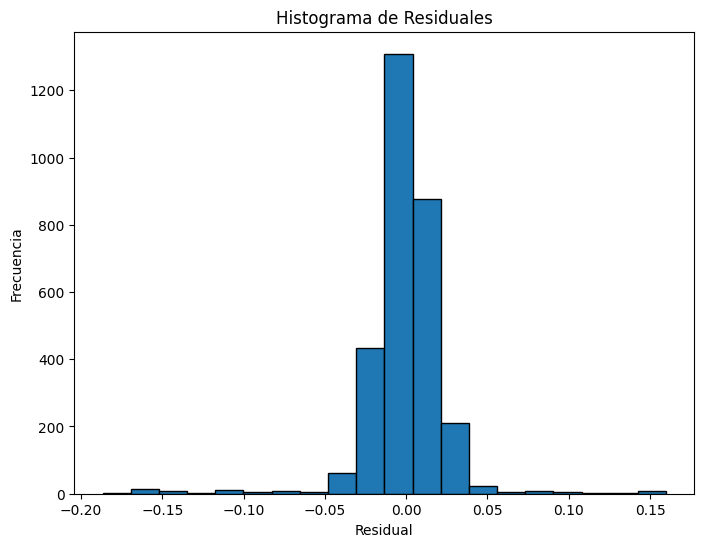

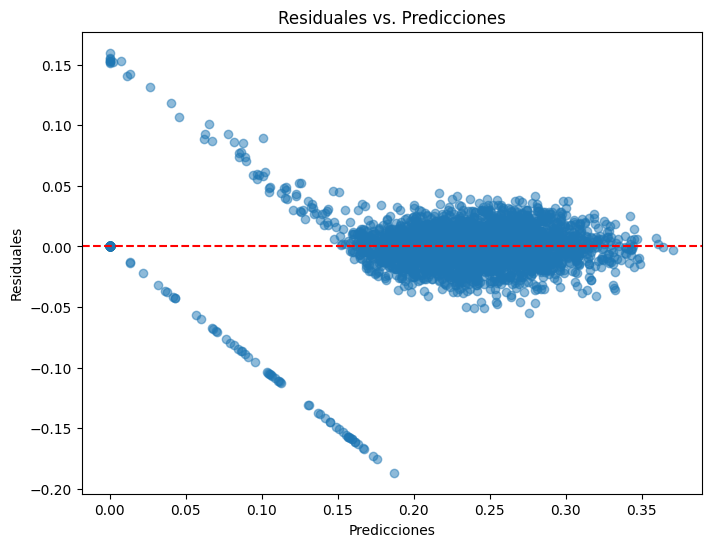

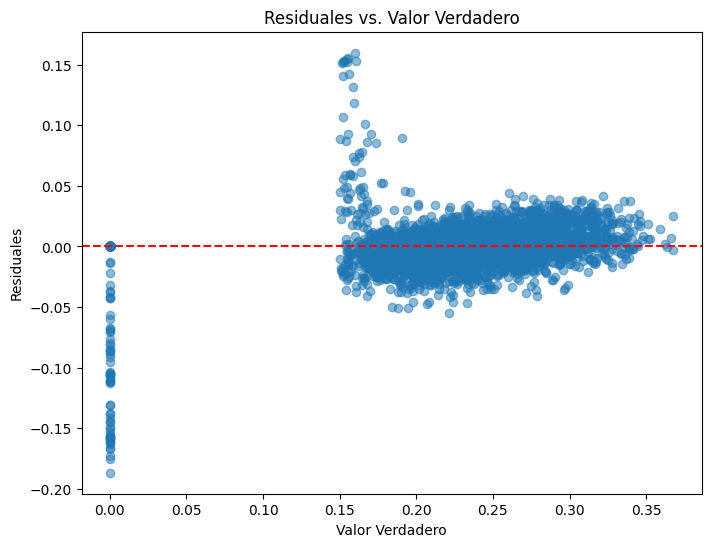

In [71]:
# Obtener las predicciones del modelo en los datos de prueba
y_pred = model1.predict(X_test).flatten()

# Calcular los residuales
residuales = y_test - y_pred

# Histograma de los residuales
plt.figure(figsize=(8, 6))
plt.hist(residuales, bins=20, edgecolor='k')
plt.title('Histograma de Residuales')
plt.xlabel('Residual')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de dispersión de los residuales vs. predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuales, alpha=0.5)
plt.title('Residuales vs. Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Gráfico de dispersión de los residuales vs. el valor verdadero
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuales, alpha=0.5)
plt.title('Residuales vs. Valor Verdadero')
plt.xlabel('Valor Verdadero')
plt.ylabel('Residuales')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

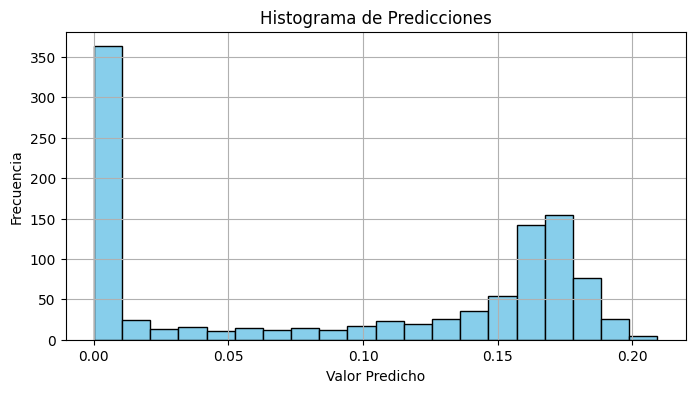

In [72]:
# Crear el histograma de las predicciones
plt.figure(figsize=(8, 4))
plt.hist(y_pred_new, bins=20, color='skyblue', edgecolor='black')
plt.title('Histograma de Predicciones')
plt.xlabel('Valor Predicho')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [52]:
df_predic = pd.DataFrame(monto_credito['ID'])
df_predic['NoPaidPer'] = y_pred_new
df_predic

,ID,NoPaidPer
0,10001,0.140010
1,10002,0.000000
2,10003,0.000000
3,10004,0.163687
4,10005,0.036590
...,...,...
1053,11054,0.185874
1054,11055,0.180757
1055,11056,0.184654
1056,11057,0.034496


In [73]:
df_predic[df_predic['NoPaidPer']<0]

,ID,NoPaidPer,int_rc


In [74]:

# Asignar la tasa de riesgo
df_predic['int_rc'] = np.where(df_predic['NoPaidPer'] < 0.15, 0.12, df_predic['NoPaidPer'] * 0.8)

# Mostrar los resultados
df_predic.head()

,ID,NoPaidPer,int_rc
0,10001,0.140010,0.12000
1,10002,0.000000,0.12000
2,10003,0.000000,0.12000
3,10004,0.163687,0.13095
4,10005,0.036590,0.12000


In [75]:
df_predic['int_rc'].value_counts()

int_rc
0.120000    616
0.133047      1
0.158899      1
0.131425      1
0.133043      1
           ... 
0.162109      1
0.131549      1
0.137319      1
0.126459      1
0.145885      1
Name: count, Length: 443, dtype: int64

In [76]:
df_predic.to_csv('salidas/predicciones.csv', index=False)

In [77]:
grupo_2 = pd.DataFrame(df_predic[['ID','int_rc']])
grupo_2['int_rc'].value_counts()

int_rc
0.120000    616
0.133047      1
0.158899      1
0.131425      1
0.133043      1
           ... 
0.162109      1
0.131549      1
0.137319      1
0.126459      1
0.145885      1
Name: count, Length: 443, dtype: int64

In [78]:
grupo_2.to_csv('salidas/grupo_2.csv', index=False)

### **Modelo con afinamiento**

In [79]:
y_pred_new = best_model.predict(df_newcredit_sc)

# Obtener las predicciones del modelo en los datos de prueba
y_pred = best_model.predict(X_test).flatten()

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


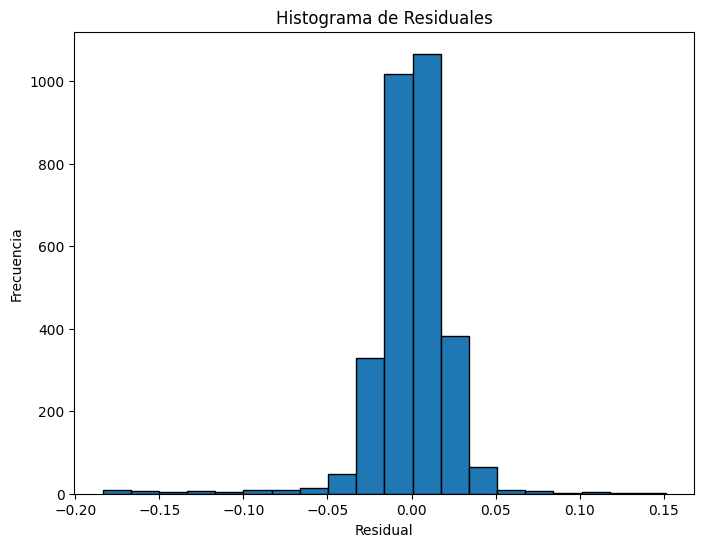

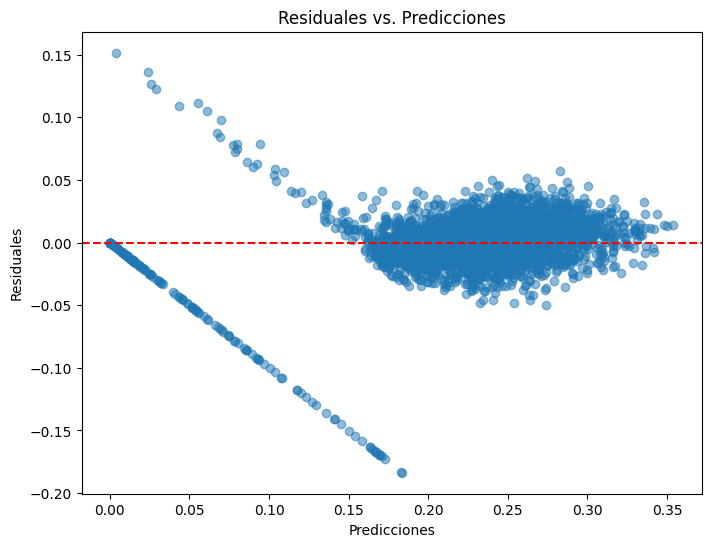

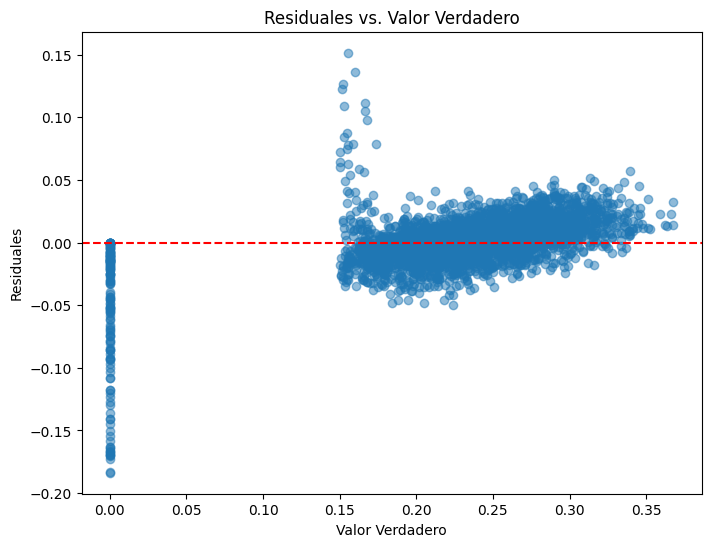

In [80]:
# Calcular los residuales
residuales = y_test - y_pred

# Histograma de los residuales
plt.figure(figsize=(8, 6))
plt.hist(residuales, bins=20, edgecolor='k')
plt.title('Histograma de Residuales')
plt.xlabel('Residual')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de dispersión de los residuales vs. predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuales, alpha=0.5)
plt.title('Residuales vs. Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Gráfico de dispersión de los residuales vs. el valor verdadero
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuales, alpha=0.5)
plt.title('Residuales vs. Valor Verdadero')
plt.xlabel('Valor Verdadero')
plt.ylabel('Residuales')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

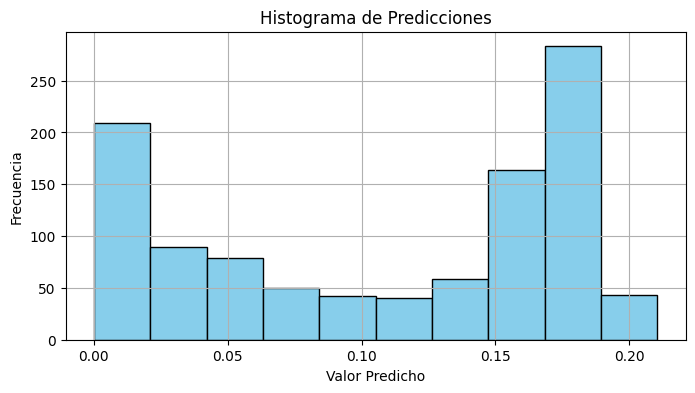

In [81]:
# Crear el histograma de las predicciones
plt.figure(figsize=(8, 4))
plt.hist(y_pred_new, bins=10, color='skyblue', edgecolor='black')
plt.title('Histograma de Predicciones')
plt.xlabel('Valor Predicho')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

### **Tasa de riesgo**

In [36]:
df_predic_afi = pd.DataFrame(monto_credito['ID'])
df_predic_afi['NoPaidPer'] = y_pred_new
df_predic_afi

,ID,NoPaidPer
0,10001,0.162725
1,10002,0.117755
2,10003,0.119245
3,10004,0.142480
4,10005,0.143259
...,...,...
1053,11054,0.133877
1054,11055,0.168269
1055,11056,0.236320
1056,11057,0.164086


In [37]:
df_predic_afi[df_predic_afi['NoPaidPer']<0]

,ID,NoPaidPer


In [ ]:
# Asignar la tasa de riesgo de 12% para aquellos con tasa ajustada menor al 15%
df_predic_afi['int_rc'] = np.where(df_predic_afi['NoPaidPer'] < 0.15, 0.12, df_predic['NoPaidPer'] * 0.8 )
# Mostrar los resultados
df_predic_afi['int_rc'].head(20)

0     0.120000
1     0.120000
2     0.120000
3     0.120000
4     0.120000
5     0.120000
6     0.120000
7     0.120000
8     0.134645
9     0.139382
10    0.120000
11    0.120000
12    0.120000
13    0.120000
14    0.120000
15    0.120000
16    0.120000
17    0.120000
18    0.129326
19    0.120000
Name: int_rc, dtype: float32

In [ ]:
df_predic_afi.to_csv('salidas/predicciones_afinamiento.csv', index=False)

In [ ]:
grupo_2_afin = pd.DataFrame(df_predic_afi[['ID','int_rc']])
grupo_2_afin['int_rc'].value_counts()

int_rc
0.120000    761
0.141430      1
0.132673      1
0.143554      1
0.162671      1
           ... 
0.129702      1
0.129927      1
0.120974      1
0.148474      1
0.167522      1
Name: count, Length: 298, dtype: int64

In [ ]:
grupo_2_afin.to_csv('salidas/grupo_2_afina.csv', index=False)

## <font color = '157699'> XGBoost

In [31]:
#pip install xgboost

In [32]:
# Librerias necesarias


In [33]:
# create model instance
bst = XGBRegressor(n_estimators=2, max_depth=2, learning_rate=1, objective='reg:squarederror')

# fit model
bst.fit(X_train, y_train)

# make predictions
preds = bst.predict(X_test)

msewr = MSE(y_test, preds)
rmsewr = np.sqrt(msewr)

print("MSE : % f" %(msewr))
print("RMSE: % f" % rmsewr)

MSE :  0.002638
RMSE:  0.051363


Optimización de hiperparametros 

In [34]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
)

param_grid = {
    'n_estimators': [10, 50, 100, 500, 1000, 5000],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_n_estimators = grid_search.best_params_['n_estimators']
best_model = grid_search.best_estimator_

best_n_estimators

#Entrenamos el modelo luego de la optimizacion de hiperparametros
best_model.fit(X_train, y_train)

# make predictions
preds = best_model.predict(X_test)

msewr = MSE(y_test, preds)
rmsewr = np.sqrt(msewr)

print("MSE : % f" %(msewr))
print("RMSE: % f" % rmsewr)

MSE :  0.000706
RMSE:  0.026579


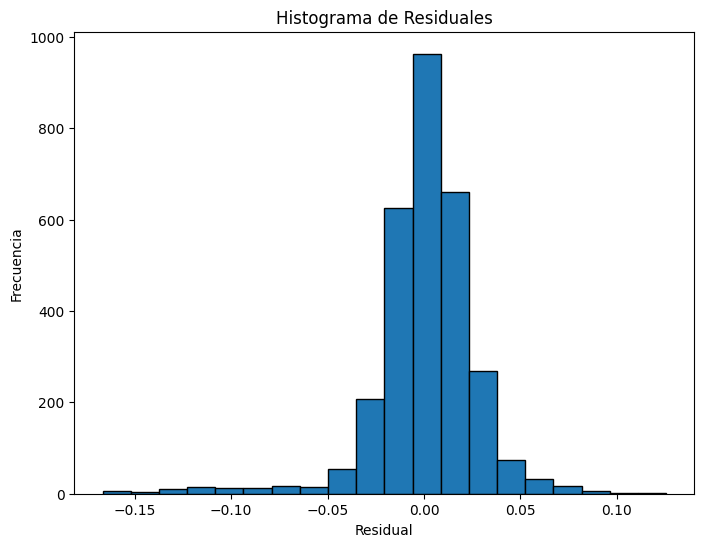

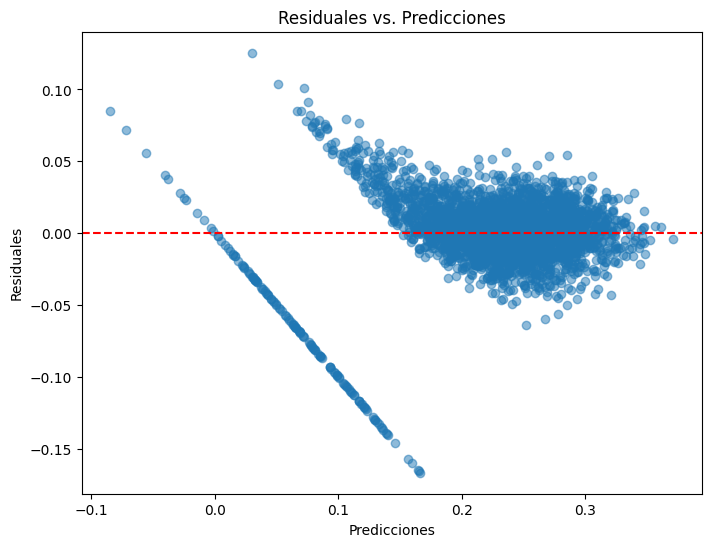

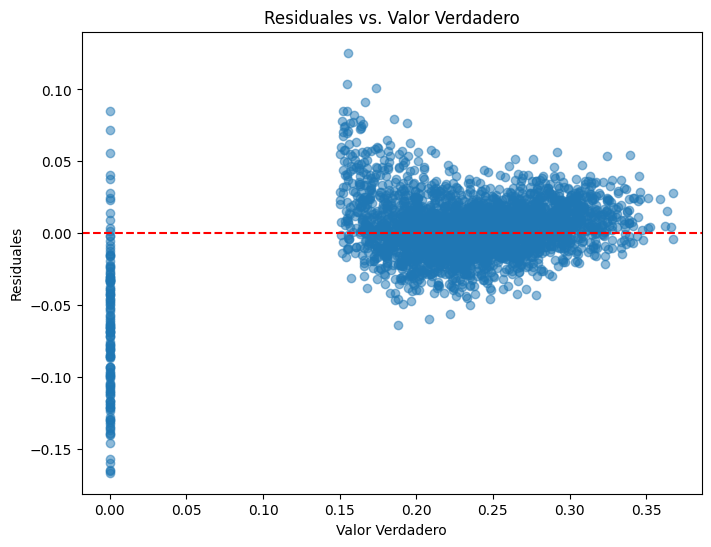

In [35]:
# Obtener las predicciones del modelo en los datos de prueba
y_pred = preds

# Calcular los residuales
residuales = y_test - y_pred

# Histograma de los residuales
plt.figure(figsize=(8, 6))
plt.hist(residuales, bins=20, edgecolor='k')
plt.title('Histograma de Residuales')
plt.xlabel('Residual')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de dispersión de los residuales vs. predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuales, alpha=0.5)
plt.title('Residuales vs. Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Gráfico de dispersión de los residuales vs. el valor verdadero
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuales, alpha=0.5)
plt.title('Residuales vs. Valor Verdadero')
plt.xlabel('Valor Verdadero')
plt.ylabel('Residuales')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

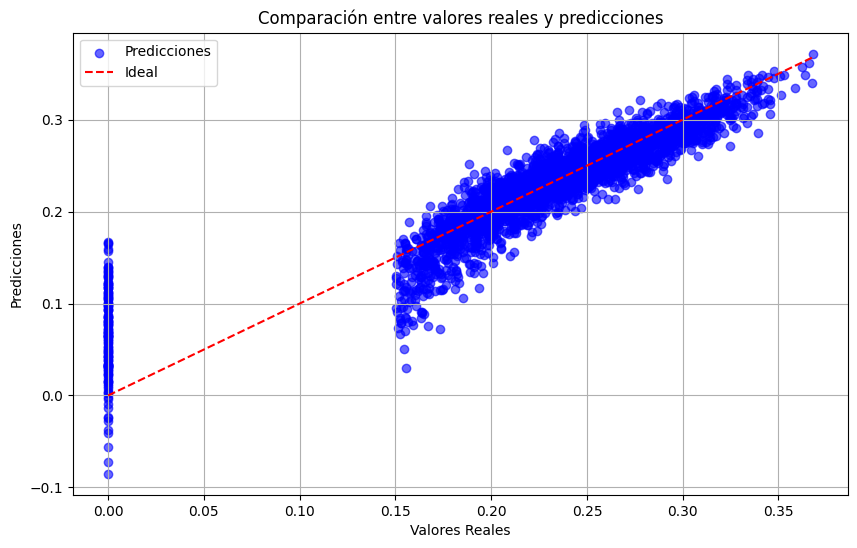

In [36]:


#Comparación de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds, color='blue', label='Predicciones', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación entre valores reales y predicciones')
plt.legend()
plt.grid(True)
plt.show()

## <font color = '157699'> Random Forest 

In [37]:
# Modelo de Bosques Aleatorios
random_model = RandomForestRegressor()

# Entrenamiento de modelo
random_model.fit(X_train, y_train)

# Predicciones
preds_random_train = random_model.predict(X_train)
preds_random_test = random_model.predict(X_test)

In [38]:
# Métricas en train
msewr = MSE(y_train, preds_random_train)
rmsewr = np.sqrt(msewr)

print("MSE_train : % f" %(msewr))
print("RMSE_train: % f" % rmsewr)

MSE_train :  0.000145
RMSE_train:  0.012039


In [39]:
# Métricas en test
msewr = MSE(y_test, preds_random_test)
rmsewr = np.sqrt(msewr)

print("MSE_test : % f" %(msewr))
print("RMSE_test: % f" % rmsewr)

MSE_test :  0.001030
RMSE_test:  0.032095


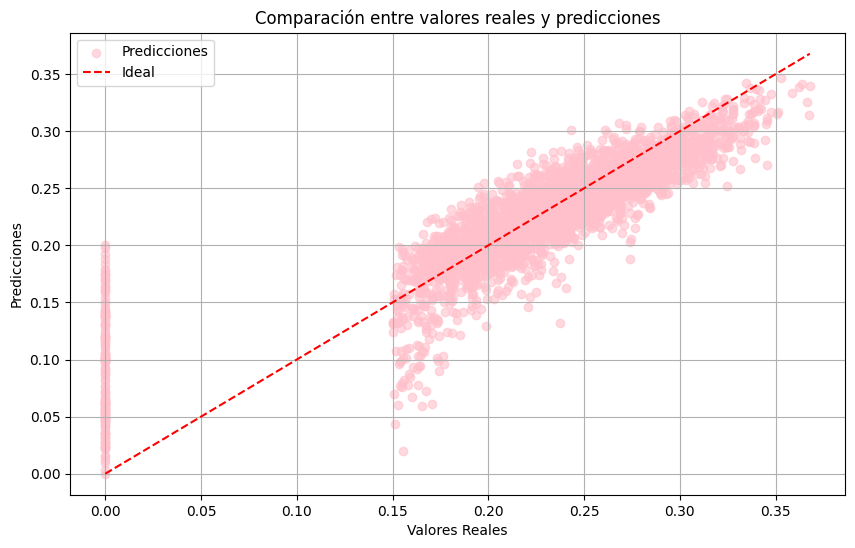

In [40]:
#Comparación de predicciones vs valores reales

plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds_random_test, color='pink', label='Predicciones', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación entre valores reales y predicciones')
plt.legend()
plt.grid(True)
plt.show()

## <font color = '157699'> Regresión Lineal


In [41]:
# Modelo de Regresión Lineal
regression_model = LinearRegression()

# Entrenamiento de modelo
regression_model.fit(X_train, y_train)

# Predicciones
preds_train = regression_model.predict(X_train)
preds_test = regression_model.predict(X_test)

In [42]:
# Métricas en train
msewr = MSE(y_train, preds_train)
rmsewr = np.sqrt(msewr)

print("MSE_train : % f" %(msewr))
print("RMSE_train: % f" % rmsewr)

MSE_train :  0.001440
RMSE_train:  0.037941


In [43]:
# Métricas en test
msewr = MSE(y_test, preds_test)
rmsewr = np.sqrt(msewr)

print("MSE_test : % f" %(msewr))
print("RMSE_test: % f" % rmsewr)

MSE_test :  0.001456
RMSE_test:  0.038157


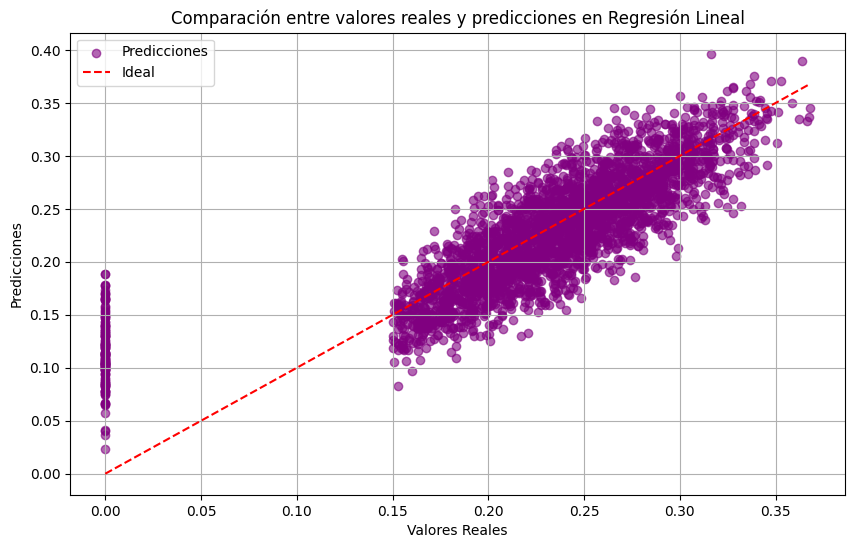

In [44]:
#Comparación de predicciones vs valores reales

plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds_test, color='purple', label='Predicciones', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación entre valores reales y predicciones en Regresión Lineal')
plt.legend()
plt.grid(True)
plt.show()